---

<h2 style="text-align: center;"><b>Свёрточные нейронные сети: CIFAR10</b></h3>

---

В этом ноутбке мы посмотрим, насколько хорошо CNN будут предсказывать классы на более сложном датасете картинок -- CIFAR10. 

**Внимание:** Рассматривается ***задача классификации изображений***.

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**.

Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с изображениями**, следовательно, на вход они тоже "ожидают" изображение.

* Например, вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>  
  
Свёрточные нейросети (простые, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*L -> FC`  

то есть:  

1). ***Входной слой***: batch картинок -- тензор размера `(batch_size, H, W, C)` или `(batch_size, C, H, W)`

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $L$ штук FullyConnected-слоёв (с активациями). Эту часть из $L$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (`weight_decay`, для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

In [ ]:
# !pip install torch torchvision

In [ ]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


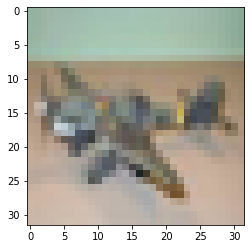

In [ ]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i]);

Напишем свёрточную нейросеть для предсказания на CIFAR10.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SimpleConvNet(torch.nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(SimpleConvNet, self).__init__()
        # feature extractor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # classificator
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
net = SimpleConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # выводим качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


[1,  2000] loss: 2.014
[1,  4000] loss: 1.792
[1,  6000] loss: 1.710
[1,  8000] loss: 1.654
[1, 10000] loss: 1.613
[1, 12000] loss: 1.592



[2,  2000] loss: 1.533
[2,  4000] loss: 1.500
[2,  6000] loss: 1.490
[2,  8000] loss: 1.479
[2, 10000] loss: 1.454
[2, 12000] loss: 1.454



[3,  2000] loss: 1.409
[3,  4000] loss: 1.393
[3,  6000] loss: 1.385
[3,  8000] loss: 1.377
[3, 10000] loss: 1.369
[3, 12000] loss: 1.361


Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 75 %
Accuracy of  bird : 31 %
Accuracy of   cat : 25 %
Accuracy of  deer : 22 %
Accuracy of   dog : 33 %
Accuracy of  frog : 74 %
Accuracy of horse : 70 %
Accuracy of  ship : 66 %
Accuracy of truck : 57 %


Проверим работу нейросети визуально (позапускайте ячейку несколько раз):

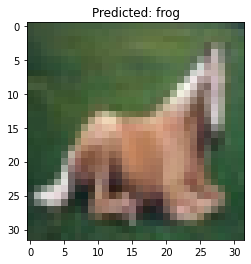

In [ ]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image)  # не забудем отмасштабировать!
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Улучшим свёрточную нейросеть: поэкспериментируем с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [ ]:
class BetterConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(BetterConvNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        
        self.fc1 = nn.Linear(3 * 3 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.conv3(F.relu(self.conv2(x))))
#         print(x.shape)
        x = x.view(-1, 3 * 3 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
net = BetterConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


[1,  2000] loss: 1.956
[1,  4000] loss: 1.703
[1,  6000] loss: 1.596
[1,  8000] loss: 1.552
[1, 10000] loss: 1.509
[1, 12000] loss: 1.516



[2,  2000] loss: 1.468
[2,  4000] loss: 1.432
[2,  6000] loss: 1.386
[2,  8000] loss: 1.390
[2, 10000] loss: 1.395
[2, 12000] loss: 1.363



[3,  2000] loss: 1.335
[3,  4000] loss: 1.312
[3,  6000] loss: 1.306
[3,  8000] loss: 1.314
[3, 10000] loss: 1.294
[3, 12000] loss: 1.322



[4,  2000] loss: 1.267
[4,  4000] loss: 1.231
[4,  6000] loss: 1.237
[4,  8000] loss: 1.246
[4, 10000] loss: 1.247
[4, 12000] loss: 1.267



[5,  2000] loss: 1.184
[5,  4000] loss: 1.184
[5,  6000] loss: 1.182
[5,  8000] loss: 1.203
[5, 10000] loss: 1.212
[5, 12000] loss: 1.194


Обучение закончено


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 68 %
Accuracy of  bird : 42 %
Accuracy of   cat : 37 %
Accuracy of  deer : 46 %
Accuracy of   dog : 50 %
Accuracy of  frog : 74 %
Accuracy of horse : 65 %
Accuracy of  ship : 61 %
Accuracy of truck : 71 %


Если качество ~70% в среднем, то текущая нейросеть вполне неплоха (однако на этом датасете известны архитектуры, дающие 95+% качества).

Посмотрим визуально на работу нейросети:

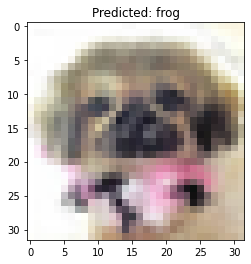

In [ ]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image)  # не забудем отмасштабировать!
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Попробуем обучить ещё более сильную нейросеть:

In [ ]:
class StrongConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора класса nn.Module()
        super(StrongConvNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(p=0.2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(4 * 4 * 32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
#         print(x.shape)
        x = x.view(-1, 4 * 4 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Обучим:

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
from torch.optim import lr_scheduler

In [ ]:
net = StrongConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 5

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
learning_rate = 1e-3
# новая фишка -- динамически изменяем LR
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in tqdm_notebook(range(num_epochs)):
    
    scheduler.step()
    
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        
        optimizer.zero_grad()

        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[1,  2000] loss: 1.874
[1,  4000] loss: 1.651
[1,  6000] loss: 1.582
[1,  8000] loss: 1.504
[1, 10000] loss: 1.438
[1, 12000] loss: 1.420



[2,  2000] loss: 1.306
[2,  4000] loss: 1.263
[2,  6000] loss: 1.250
[2,  8000] loss: 1.242
[2, 10000] loss: 1.235
[2, 12000] loss: 1.209



[3,  2000] loss: 1.089
[3,  4000] loss: 1.085
[3,  6000] loss: 1.064
[3,  8000] loss: 1.093
[3, 10000] loss: 1.101
[3, 12000] loss: 1.068



[4,  2000] loss: 0.979
[4,  4000] loss: 0.974
[4,  6000] loss: 0.973
[4,  8000] loss: 0.970
[4, 10000] loss: 0.996
[4, 12000] loss: 0.979



[5,  2000] loss: 0.935
[5,  4000] loss: 0.945
[5,  6000] loss: 0.936
[5,  8000] loss: 0.941
[5, 10000] loss: 0.940
[5, 12000] loss: 0.944


Обучение закончено


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 75 %
Accuracy of  bird : 47 %
Accuracy of   cat : 41 %
Accuracy of  deer : 54 %
Accuracy of   dog : 51 %
Accuracy of  frog : 67 %
Accuracy of horse : 65 %
Accuracy of  ship : 74 %
Accuracy of truck : 73 %


Посмотрим визуально на работу нейросети:

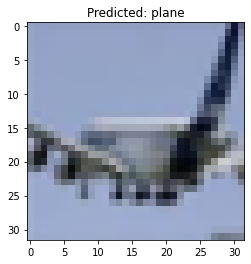

In [ ]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index]
    plt.imshow(image)
    
    image = transform(image)  # не забудем отмасштабировать!
    
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

Даже обучив более глубокую и прокаченную (BatchNorm, Dropout) нейросеть на этих данных мы видим, что качество нас всё ещё не устраивает, в реальной жизни необходимо ошибаться не больше, чем на 5%, а часто и это уже много. Как же быть, ведь свёрточные нейросети должны хорошо классифицировать изображения?  

К сожалению, обучение нейросети с нуля на не очень большой выборке (а здесь она именно такая) часто приводит к переобучению, что плохо сказывается на тестовом качестве.  

Для того, чтобы получить более качественную модель, часто **до**обучают сильную нейросеть, обученную на ImageNet, то есть используют технику Transfer Learning. О ней речь пойдёт далее в нашем курсе.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (официальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). Курс Стэнфорда:  http://cs231n.github.io/

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M